In [125]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1e2jg-Fp2LlC4wC9clRDel3CImlLte4w1
!unzip archive.zip

Downloading...
From: https://drive.google.com/uc?id=1e2jg-Fp2LlC4wC9clRDel3CImlLte4w1
To: /content/archive.zip
100% 6.33k/6.33k [00:00<00:00, 23.4MB/s]
Archive:  archive.zip
replace heart.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: heart.csv               


In [126]:
!pip install scikit-fuzzy
!pip install joblib
!pip install --upgrade streamlit
!pip install --upgrade pyngrok

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:


import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import os
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import streamlit as st
from pyngrok import ngrok

In [129]:
df = pd.read_csv("heart.csv")
print(df.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


In [130]:
binary_features = ['sex', 'fbs', 'exang']

binary_data = df[binary_features]
X = df.drop(columns=['target'] + binary_features)

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

df_normalized = pd.DataFrame(X_normalized, columns=X.columns)

print(df_normalized.head())

        age   cp  trestbps      chol  restecg   thalach   oldpeak  slope  \
0  0.479167  0.0  0.292453  0.196347      0.5  0.740458  0.161290    1.0   
1  0.500000  0.0  0.433962  0.175799      0.0  0.641221  0.500000    0.0   
2  0.854167  0.0  0.481132  0.109589      0.5  0.412214  0.419355    0.0   
3  0.666667  0.0  0.509434  0.175799      0.5  0.687023  0.000000    1.0   
4  0.687500  0.0  0.415094  0.383562      0.5  0.267176  0.306452    0.5   

     ca      thal  
0  0.50  1.000000  
1  0.00  1.000000  
2  0.00  1.000000  
3  0.25  1.000000  
4  0.75  0.666667  


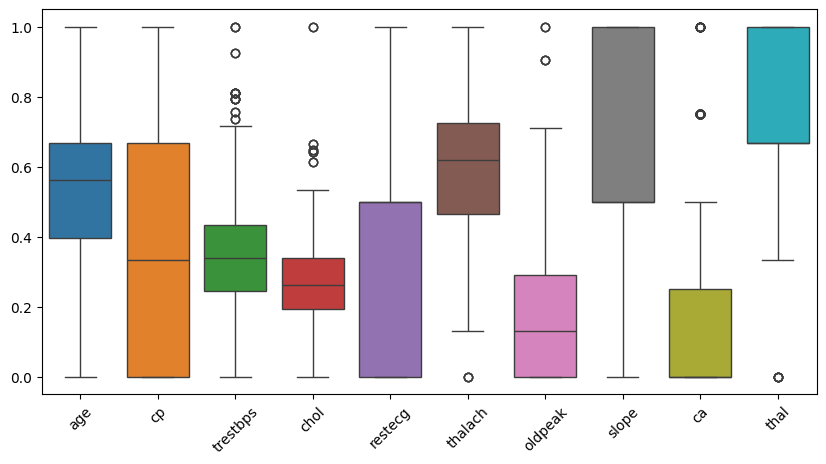

In [131]:
continuous_features = df_normalized.columns

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_normalized[continuous_features])
plt.xticks(rotation=45)
plt.show()

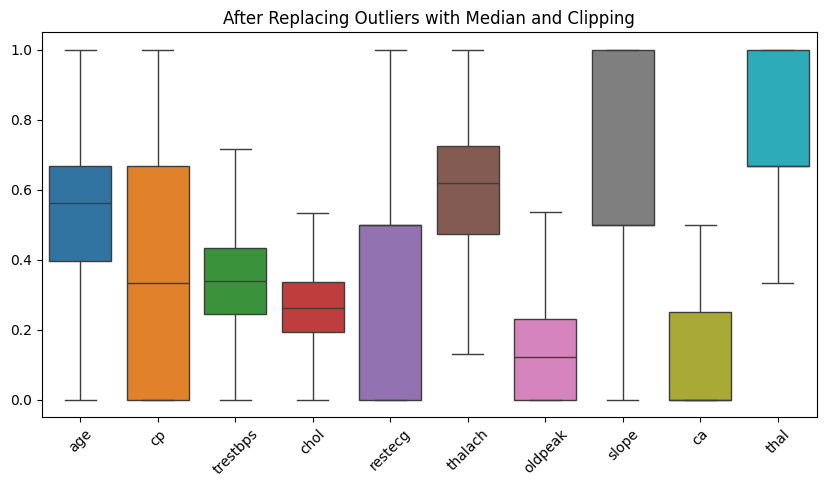


Replaced 151 outlier values with median and clipped extreme values.
Data cleaned and saved as 'heart_cleaned.csv'


In [132]:
Q1 = df_normalized.quantile(0.25)
Q3 = df_normalized.quantile(0.75)
IQR = Q3 - Q1

# شناسایی داده‌های پرت
outliers = ((df_normalized < (Q1 - 1.5 * IQR)) |
            (df_normalized > (Q3 + 1.5 * IQR)))

df_cleaned = df_normalized.copy()

for feature in df_normalized.columns:
    median_value = df_cleaned[feature].median()

    # جایگزینی مقادیر پرت با میانه
    df_cleaned.loc[outliers[feature], feature] = median_value

    # CLIP کردن مقادیر خیلی بزرگ یا خیلی کوچک
    lower_bound = Q1[feature] - 1.5 * IQR[feature]
    upper_bound = Q3[feature] + 1.5 * IQR[feature]
    df_cleaned[feature] = df_cleaned[feature].clip(lower=lower_bound, upper=upper_bound)

# **اعمال تبدیل Log روی ویژگی‌های دارای چولگی زیاد**
df_cleaned['oldpeak'] = np.log1p(df_cleaned['oldpeak'])  # log(x+1) برای جلوگیری از log(0)

# رسم جعبه‌نمودار بعد از جایگزینی مقادیر پرت
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_cleaned[continuous_features])
plt.xticks(rotation=45)
plt.title("After Replacing Outliers with Median and Clipping")
plt.show()

outlier_count = outliers.sum().sum()
print(f"\nReplaced {outlier_count} outlier values with median and clipped extreme values.")

# ذخیره داده‌های اصلاح‌شده
df_cleaned.to_csv("heart_cleaned.csv", index=False)
print("Data cleaned and saved as 'heart_cleaned.csv'")


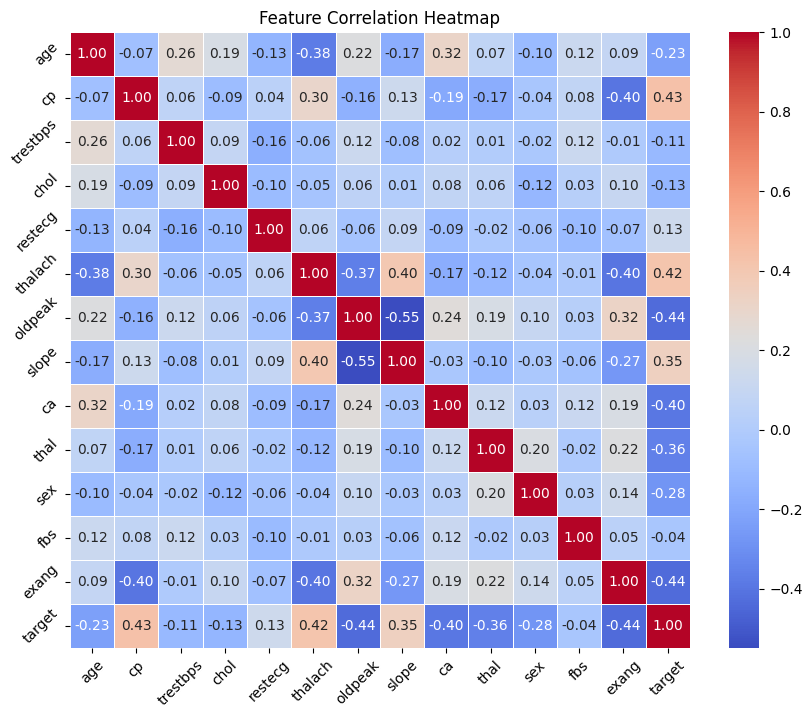

In [133]:
df_cleaned[binary_features] = binary_data
df_cleaned['target'] = df['target']

plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Feature Correlation Heatmap")
plt.show()

In [134]:
X_train = df_cleaned.iloc[:, :-1]
y_train = df_cleaned.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 615
Validation size: 205
Test size: 205


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6293 - loss: 0.7725 - val_accuracy: 0.8000 - val_loss: 0.7525 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7866 - loss: 0.5496 - val_accuracy: 0.8049 - val_loss: 0.7155 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8316 - loss: 0.4780 - val_accuracy: 0.8341 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8406 - loss: 0.4540 - val_accuracy: 0.8585 - val_loss: 0.6507 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8736 - loss: 0.3982 - val_accuracy: 0.8732 - val_loss: 0.6227 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8923 - loss: 0.3994 - val_accuracy: 0.8829 - val_loss: 0.6011 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8584 - loss: 0.4210 - val_accuracy: 

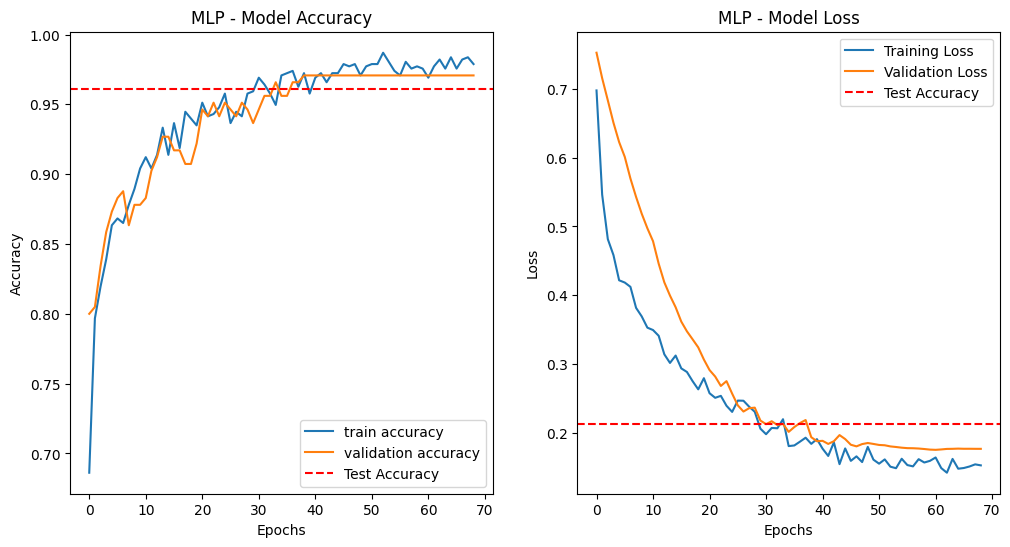

In [135]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation=None,
                          kernel_regularizer=regularizers.l2(0.0005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(64, activation=None, kernel_regularizer=regularizers.l2(0.0005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr]
                    )

# پیش‌بینی مدل
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# محاسبه معیارهای ارزیابی
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MLP Accuracy: {accuracy * 100:.2f}%")
print(f"MLP Recall: {recall * 100:.2f}%")
print(f"MLP Precision: {precision * 100:.2f}%")
print(f"MLP MSE: {mse* 100:.2f}%")

# ارزیابی مدل روی داده‌های تست
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# رسم نمودارها
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.title('MLP - Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Accuracy')
plt.title('MLP - Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [136]:
# مسیر ذخیره‌سازی در Google Drive
save_path = "/content/drive/MyDrive/heart_disease_MLPmodel/"

# ایجاد پوشه در گوگل درایو (اگر وجود نداشته باشد)
os.makedirs(save_path, exist_ok=True)

# ذخیره مدل
joblib.dump(model, save_path + "heart_disease_MLPmodel.pkl")
print(f"Model saved in {save_path}")

# ذخیره نرمال‌ساز
joblib.dump(scaler, save_path + "scaler.pkl")
print(f"Scaler saved in {save_path}")


Model saved in /content/drive/MyDrive/heart_disease_MLPmodel/
Scaler saved in /content/drive/MyDrive/heart_disease_MLPmodel/


Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5122 - loss: 0.7148 - val_accuracy: 0.5220 - val_loss: 0.6661 - learning_rate: 0.0010
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6489 - loss: 0.6391 - val_accuracy: 0.7317 - val_loss: 0.6475 - learning_rate: 0.0010
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6679 - loss: 0.6025 - val_accuracy: 0.7902 - val_loss: 0.6314 - learning_rate: 0.0010
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6949 - loss: 0.5657 - val_accuracy: 0.7756 - val_loss: 0.6272 - learning_rate: 0.0010
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6996 - loss: 0.5974 - val_accuracy: 0.7805 - val_loss: 0.6136 - learning_rate: 0.0010
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7022 - loss: 0.5565 - val_accuracy: 0.7854 - val_loss: 0.6016 - learning_rate: 0.0010
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7076 - loss: 0.5672 - val_ac

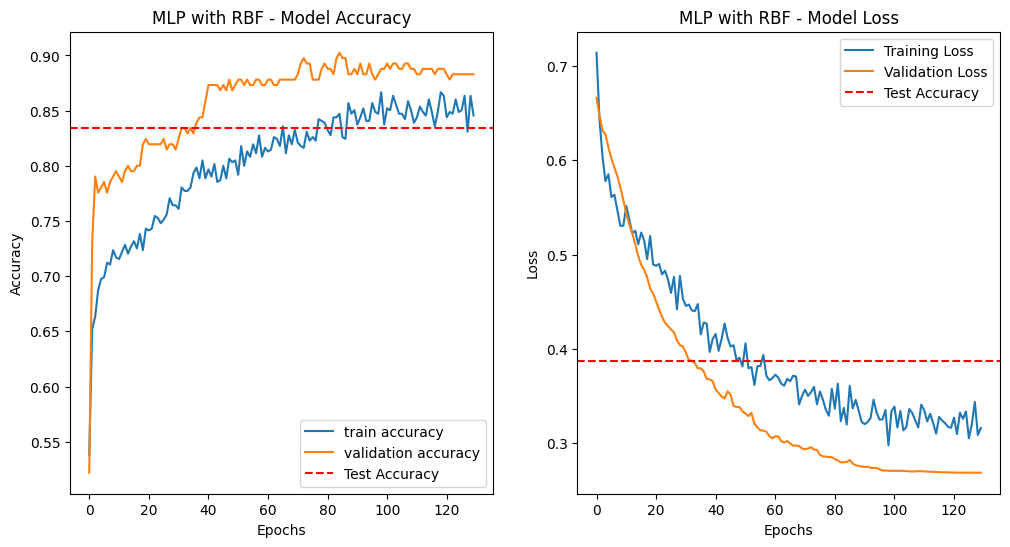

In [137]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# تعریف لایه RBF با اصلاحات
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, sigma=1.0):
        super(RBFLayer, self).__init__()
        self.units = units  # تعداد مراکز (نرون‌ها)
        self.sigma = sigma  # انحراف معیار
        self.centers = None  # مراکز نرون‌ها

    def build(self, input_shape):
        # در اینجا مراکز را به‌صورت تصادفی با تعداد ویژگی‌های ورودی می‌سازیم
        self.centers = self.add_weight(name="centers",
                                       shape=(self.units, input_shape[1]),  # تغییر ابعاد
                                       initializer="random_normal")

    def call(self, inputs):
        # گسترش ابعاد ورودی‌ها
        inputs_expanded = tf.expand_dims(inputs, 1)  # تبدیل به ابعاد (batch_size, 1, input_dim)
        centers_expanded = tf.expand_dims(self.centers, 0)  # تبدیل به ابعاد (1, units, input_dim)

        # فاصله ورودی‌ها از مراکز
        diff = inputs_expanded - centers_expanded  # اختلاف بین ورودی‌ها و مراکز
        dist = tf.reduce_sum(tf.square(diff), axis=-1)  # محاسبه مربع فاصله
        return tf.exp(-dist / (2 * self.sigma ** 2))  # محاسبه خروجی RBF

# ایجاد مدل با لایه RBF
model = tf.keras.Sequential([
    RBFLayer(units=128, sigma=1.0),  # تعداد مراکز و انحراف معیار
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.4),


    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=150, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr]
                    )

# پیش‌بینی مدل
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# محاسبه معیارهای ارزیابی
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MLP Accuracy with RBF: {accuracy * 100:.2f}%")
print(f"MLP Recall with RBF: {recall * 100:.2f}%")
print(f"MLP Precision with RBF: {precision * 100:.2f}%")
print(f"MLP MSE with RBF: {mse * 100:.2f}%")

# ارزیابی مدل روی داده‌های تست
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# رسم نمودارها
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.title('MLP with RBF - Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Accuracy')
plt.title('MLP with RBF - Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [139]:
import pandas as pd
import numpy as np

# تبدیل داده‌ها به {-1, 1} برای هاپفیلد
X_train_hopfield = np.where(X_train >= 0, 1, -1)


# تبدیل به DataFrame برای تحلیل توزیع
df_train = pd.DataFrame(X_train_hopfield)
df_train['label'] = y_train

# شمارش تکرار هر الگو
pattern_counts = df_train.groupby(list(df_train.columns)).size().reset_index(name='count')

# انتخاب ۱۰ الگوی پرتکرار
top_patterns = pattern_counts.sort_values(by='count', ascending=False).head(10).drop(columns=['count'])

# تبدیل به numpy array برای استفاده در شبکه هاپفیلد
selected_patterns = top_patterns.iloc[:, :-1].values


In [145]:

class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))  # ماتریس وزن‌ها

    def train(self, patterns):
        """ آموزش شبکه با قانون Hebbian نرمال شده """
        for p in patterns:
            p = np.reshape(p, (self.size, 1))
            self.weights += np.dot(p, p.T) / self.size  # نرمال‌سازی وزن‌ها
        np.fill_diagonal(self.weights, 0)



    def predict(self, input_pattern, steps=5):
        """ اجرای شبکه و بازیابی خروجی """
        output = np.reshape(input_pattern, (self.size, 1))  # تغییر شکل ورودی
        for _ in range(steps):
            output = np.sign(np.dot(self.weights, output))
        return output.flatten()  # تبدیل به آرایه 1D


X_train_hopfield = np.where(X_train >= 0, 1, -1)  # تبدیل داده‌ها به {-1, 1}
X_test_hopfield = np.where(X_test >= 0, 1, -1)


hopfield = HopfieldNetwork(size=X_train.shape[1])
hopfield.train(X_train_hopfield)

y_pred_hopfield = np.array([hopfield.predict(x) for x in X_test_hopfield])
y_pred_hopfield = (y_pred_hopfield[:, 0] > 0).astype(int)  # تبدیل خروجی به کلاس 0 و 1

accuracy_hopfield = accuracy_score(y_test, y_pred_hopfield)
recall_hopfield = recall_score(y_test, y_pred_hopfield)
precision_hopfield = precision_score(y_test, y_pred_hopfield)
mse_hopfield = mean_squared_error(y_test, y_pred_hopfield)


print(f"Hopfield Accuracy : {accuracy_hopfield * 100:.2f}%")
print(f"Hopfield Recall : {recall_hopfield * 100:.2f}%")
print(f"Hopfield Precision: {precision_hopfield * 100:.2f}%")
print(f"Hopfield MSE: {mse_hopfield * 100:.2f}%")


Hopfield Accuracy : 50.24%
Hopfield Recall : 100.00%
Hopfield Precision: 50.24%
Hopfield MSE: 49.76%


In [146]:
def gaussian_membership(value, mean, std_dev):
    return np.exp(-0.5 * ((value - mean) / std_dev) ** 2)

# تبدیل داده‌ها به فازی با استفاده از عضویت گوسی
def fuzzy_transform_gaussian(data):
    fuzzy_data = []

    # برای هر ویژگی در داده‌ها
    for feature_name, feature in data.items():  # داده‌ها به صورت ویژگی‌ها (ستون‌ها)
        mean = np.mean(feature)
        std_dev = np.std(feature)  # انحراف معیار داده‌ها

        fuzzy_feature = []

        # برای هر مقدار در ویژگی، محاسبه عضویت گوسی
        for value in feature:
            fuzzy_value = gaussian_membership(value, mean, std_dev)  # محاسبه عضویت گوسی
            fuzzy_feature.append(fuzzy_value)  # اضافه کردن عضویت‌ها

        fuzzy_data.append(np.array(fuzzy_feature))  # تبدیل به عضویت‌های گوسی

    return np.array(fuzzy_data)  # بازگرداندن به فرم داده‌های فازی

# تبدیل داده‌های نرمال‌شده به داده‌های فازی


# = fuzzy_transform_gaussian(df_cleaned.drop(columns=['target'] + binary_features))
fuzzy_data = fuzzy_transform_gaussian(df_cleaned.drop(columns=['target']))

# داده‌های فازی را به فرم مناسب برای تحلیل بیشتر تبدیل می‌کنیم
X = fuzzy_data.T  # تغییر ابعاد برای اینکه به شکل (1025, تعداد ویژگی‌ها) باشد
print(f"Reshaped fuzzy_data shape: {X.shape}")  # این باید (1025, تعداد ویژگی‌ها) باشد

# حالا هدف‌ها را جدا می‌کنیم
y = df_cleaned['target'].values  # تعداد نمونه‌ها باید 1025 باشد

# بررسی اندازه‌ها
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)



Reshaped fuzzy_data shape: (1025, 13)
Shape of y: (1025,)


In [147]:
model = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_split=15, min_samples_leaf=1, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Fuzzy Accuracy: {accuracy * 100:.2f}%")

recall = recall_score(y_test, y_pred)
print(f"Fuzzy Recall: {recall * 100:.2f}%")

precision = precision_score(y_test, y_pred)
print(f"Fuzzy Precision: {precision * 100:.2f}%")

mse = mean_squared_error(y_test, y_pred)
print(f"Fuzzy MSE: {mse * 100:.2f}%")

Fuzzy Accuracy: 94.63%
Fuzzy Recall: 99.03%
Fuzzy Precision: 91.07%
Fuzzy MSE: 5.37%


In [148]:
joblib.dump(model, 'heart_disease_FuzzyModel.pkl')
print("heart_disease_FuzzyModel.pkl saved.")

save_path = "/content/drive/MyDrive/heart_disease_FuzzyModel/"
os.makedirs(save_path, exist_ok=True)
joblib.dump(model, save_path + "heart_disease_rf.pkl")

print(f"in {save_path} saved.")

# مسیر ذخیره‌سازی در Google Drive
save_path = "/content/drive/MyDrive/heart_disease_FuzzyModel/"

# ایجاد پوشه در گوگل درایو (اگر وجود نداشته باشد)
os.makedirs(save_path, exist_ok=True)

# ذخیره مدل
joblib.dump(model, save_path + "heart_disease_FuzzyModel.pkl")
print(f"Model saved in {save_path}")

# ذخیره نرمال‌ساز
joblib.dump(scaler, save_path + "scaler.pkl")
print(f"Scaler saved in {save_path}")

heart_disease_FuzzyModel.pkl saved.
in /content/drive/MyDrive/heart_disease_FuzzyModel/ saved.
Model saved in /content/drive/MyDrive/heart_disease_FuzzyModel/
Scaler saved in /content/drive/MyDrive/heart_disease_FuzzyModel/


In [149]:
# ایجاد مدل درخت تصمیم با محدودیت‌های regularization
model = DecisionTreeClassifier(random_state=42, max_depth=20, min_samples_split=16, min_samples_leaf=4)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall * 100:.2f}%")

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision * 100:.2f}%")

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")


Accuracy: 87.80%
Recall: 82.52%
Precision: 92.39%
MSE: 0.1220


In [150]:
!pip install --upgrade streamlit

!pip install --upgrade pyngrok

In [151]:
%%writefile app.py

model = joblib.load('/content/drive/MyDrive/heart_disease_MLPmodel/heart_disease_MLPmodel.pkl')
scaler = joblib.load('/content/drive/MyDrive/heart_disease_MLPmodel/scaler.pkl')


st.title('Diagnosis of Heart Diseases')
st.header("Enter your information:")

# گرفتن ورودی‌های کاربر
age = st.number_input('Age:', min_value=0, max_value=120)
sex = st.selectbox('Sex:', ['man', 'woman'])
cp = st.selectbox('cp:', [0, 1, 2, 3])
trestbps = st.number_input('trestbps:', min_value=0, max_value=300)
chol = st.number_input('chol:', min_value=0, max_value=400)
fbs = st.selectbox('fbs:', [0, 1])
restecg = st.selectbox('restecg:', [0, 1, 2])
thalach = st.number_input('thalach:', min_value=0, max_value=250)
exang = st.selectbox('exang:', [0, 1])
oldpeak = st.number_input('oldpeak:', min_value=0.0, max_value=10.0)
slope = st.selectbox('slope:', [0, 1, 2])
ca = st.selectbox('ca:', [0, 1, 2, 3, 4])
thal = st.selectbox('thal:', [0, 1, 2, 3])

# پردازش داده‌های ورودی
sex_bin = 1 if sex == 'man' else 0
fbs_bin = fbs
exang_bin = exang

numerical_features = np.array([
    age, cp, trestbps, chol, restecg, thalach, oldpeak, slope, ca, thal
]).reshape(1, -1)

# نرمال‌سازی داده‌ها
numerical_features_scaled = scaler.transform(numerical_features)

# ترکیب ویژگی‌های عددی و باینری
features_scaled = np.hstack([numerical_features_scaled, np.array([[sex_bin, fbs_bin, exang_bin]])])



if st.button("predict"):

    prediction = model.predict(features_scaled)

    if prediction > 0.5:
        st.write(f"There is a probability of heart disease:(")
    else:
        st.write(f"There is no probability of heart disease:)")

    #st.write(f"probability: {probability * 100:.2f}%")


Overwriting app.py


In [153]:
!pkill -f streamlit
!pkill -f ngrok


In [154]:
!streamlit run /content/drive/MyDrive/app.py --server.port 8501 --server.enableCORS false --server.enableXsrfProtection false &> /dev/null &


In [155]:
!ngrok authtoken 2sb5ZssRu1UlqCGFCUSrIodPMIQ_59fJnLHLd6BfYMbsF41wc

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [156]:
!streamlit run /content/drive/MyDrive/app.py --server.port 8501 --server.enableCORS false --server.enableXsrfProtection false &>/dev/null &


In [157]:
!ps aux | grep streamlit


In [158]:
ngrok.kill()
# ایجاد تونل ngrok برای پورت 8501
public_url = ngrok.connect(8501)
print(f"Ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:8501\"")


Ngrok tunnel "NgrokTunnel: "https://7d20-34-169-31-119.ngrok-free.app" -> "http://localhost:8501"" -> "http://127.0.0.1:8501"
